In [1]:
from mebocost import mebocost as mb
import anndata
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        
        sys.stdout = self._original_stdout
        

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
count_mat = pd.read_csv("/desktop-home/heyer/projects/Vascular_Aging/RNAseq/multicondition-deseq2-enrichment/custom/tec_age_vs_young_rlog.tsv",
                        sep = "\t", index_col="gene").transpose()
#count_mat = 

In [3]:
metadata = pd.read_csv("/desktop-home/heyer/projects/Vascular_Aging/RNAseq/multicondition-deseq2-enrichment/data/tumor_vs_ec/age_vs_young.tsv",
                      sep = "\t", index_col="sample")

In [4]:
adata_test = anndata.AnnData(X = count_mat, obs= metadata)

In [5]:
adata = adata_test

adata_young = adata[adata.obs.age == "young"]

adata_aged = adata[adata.obs.age == "aged"]



In [6]:
count_mat.index

Index(['VascAge_ATC_t1', 'VascAge_ATC_t2', 'VascAge_ATC_t3', 'VascAge_ATC_t4',
       'VascAge_ATC_t5', 'VascAge_ATC_t6', 'VascAge_ATC_t7', 'VascAge_YTC_c1',
       'VascAge_YTC_c2', 'VascAge_YTC_c3', 'VascAge_YTC_c4', 'VascAge_YTC_c5',
       'VascAge_YTC_c6', 'VascAge_YTC_c7', 'VascAge_atec_t1',
       'VascAge_atec_t2', 'VascAge_atec_t3', 'VascAge_atec_t4',
       'VascAge_atec_t5', 'VascAge_atec_t6', 'VascAge_atec_t7',
       'VascAge_ytec_c1', 'VascAge_ytec_c2', 'VascAge_ytec_c3',
       'VascAge_ytec_c4', 'VascAge_ytec_c5', 'VascAge_ytec_c6',
       'VascAge_ytec_c7'],
      dtype='object')

In [7]:
print(adata.shape)
def run_mebocost(adata_obj):
    #sc.pp.normalize_total(adata_obj)
    
    mebo_obj = mb.create_obj(
                        adata = adata_obj,
                        group_col = ['condition'],
                        met_est = 'mebocost',
                        config_path = '/home/heyer/software/external/MEBOCOST/mebocost.conf',
                        exp_mat=None,
                        cell_ann=None,
                        species='mouse',
                        met_pred=None,
                        met_enzyme=None,
                        met_sensor=None,
                        met_ann=None,
                        scFEA_ann=None,
                        compass_met_ann=None,
                        compass_rxn_ann=None,
                        gene_network=None,
                        cutoff_exp='auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met='auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop=0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type=['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread=8,
                        gmt_path = "/desktop-home/heyer/projects/Vascular_Aging/RNAseq/multicondition-deseq2-enrichment/custom/m2.all.v2022.1.Mm.symbols.gmt"
                        )
    with HiddenPrints():
        commu_res = mebo_obj.infer_commu(
                                n_shuffle=2000,
                                Return=True, 
                                thread=8,
                                save_permuation=False,
                                min_cell_number = 1
                            )
    return mebo_obj

mebo_young= run_mebocost(adata_young)
    

(28, 24301)
[May 02, 2023 15:36:44]: We get expression data with 24301 genes and 14 cells.
[May 02, 2023 15:36:44]: Data Preparation Done in 0.0313 seconds


In [8]:
mebo_aged = run_mebocost(adata_aged)
mebo_all = run_mebocost(adata)

[May 02, 2023 15:38:52]: We get expression data with 24301 genes and 14 cells.
[May 02, 2023 15:38:52]: Data Preparation Done in 0.0257 seconds
[May 02, 2023 15:41:03]: We get expression data with 24301 genes and 28 cells.
[May 02, 2023 15:41:03]: Data Preparation Done in 0.0729 seconds


In [9]:


## check the metabolite estimation result
met_mat = pd.DataFrame(mebo_all.met_mat.toarray(),
                      index = mebo_all.met_mat_indexer,
                      columns = mebo_all.met_mat_columns)
met_mat.head()

,VascAge_ATC_t1,VascAge_ATC_t2,VascAge_ATC_t3,VascAge_ATC_t4,VascAge_ATC_t5,VascAge_ATC_t6,VascAge_ATC_t7,VascAge_YTC_c1,VascAge_YTC_c2,VascAge_YTC_c3,...,VascAge_atec_t5,VascAge_atec_t6,VascAge_atec_t7,VascAge_ytec_c1,VascAge_ytec_c2,VascAge_ytec_c3,VascAge_ytec_c4,VascAge_ytec_c5,VascAge_ytec_c6,VascAge_ytec_c7
HMDB0003948,10.274230,10.082434,10.209682,10.072886,10.204535,10.260775,10.200606,10.260163,10.125002,10.297698,...,10.653268,10.706629,10.598372,10.615211,10.510194,10.551948,10.435175,10.604953,10.559270,10.403052
HMDB0003712,9.556473,9.441438,9.412952,9.506239,9.542665,9.578831,9.619703,9.522372,9.493502,9.496485,...,9.865679,9.998731,9.807417,9.829271,9.725060,9.675986,9.578206,9.712007,9.688583,9.645587
HMDB0003945,10.349684,10.167784,10.286175,10.184940,10.270536,10.356446,10.260899,10.357344,10.223463,10.386622,...,10.737592,10.794149,10.682620,10.698617,10.598790,10.639862,10.533122,10.682121,10.656364,10.496200
HMDB0003949,10.274230,10.082434,10.209682,10.072886,10.204535,10.260775,10.200606,10.260163,10.125002,10.297698,...,10.653268,10.706629,10.598372,10.615211,10.510194,10.551948,10.435175,10.604953,10.559270,10.403052
HMDB0001090,-0.070361,0.130003,0.189717,-0.044545,-0.068565,0.187140,0.021349,-0.011251,0.129919,-0.098330,...,0.748446,0.969911,1.033150,1.176144,1.143068,0.964293,1.207335,0.833740,0.987029,0.664452


In [10]:
met_mat["metabolite"] = mebo_all.met_ann.set_index("HMDB_ID").loc[met_mat.index].metabolite

met_mat

,VascAge_ATC_t1,VascAge_ATC_t2,VascAge_ATC_t3,VascAge_ATC_t4,VascAge_ATC_t5,VascAge_ATC_t6,VascAge_ATC_t7,VascAge_YTC_c1,VascAge_YTC_c2,VascAge_YTC_c3,...,VascAge_atec_t6,VascAge_atec_t7,VascAge_ytec_c1,VascAge_ytec_c2,VascAge_ytec_c3,VascAge_ytec_c4,VascAge_ytec_c5,VascAge_ytec_c6,VascAge_ytec_c7,metabolite
HMDB0003948,10.274230,10.082434,10.209682,10.072886,10.204535,10.260775,10.200606,10.260163,10.125002,10.297698,...,10.706629,10.598372,10.615211,10.510194,10.551948,10.435175,10.604953,10.559270,10.403052,(2E)-Decenoyl-CoA
HMDB0003712,9.556473,9.441438,9.412952,9.506239,9.542665,9.578831,9.619703,9.522372,9.493502,9.496485,...,9.998731,9.807417,9.829271,9.725060,9.675986,9.578206,9.712007,9.688583,9.645587,(2E)-Dodecenoyl-CoA
HMDB0003945,10.349684,10.167784,10.286175,10.184940,10.270536,10.356446,10.260899,10.357344,10.223463,10.386622,...,10.794149,10.682620,10.698617,10.598790,10.639862,10.533122,10.682121,10.656364,10.496200,(2E)-Hexadecenoyl-CoA
HMDB0003949,10.274230,10.082434,10.209682,10.072886,10.204535,10.260775,10.200606,10.260163,10.125002,10.297698,...,10.706629,10.598372,10.615211,10.510194,10.551948,10.435175,10.604953,10.559270,10.403052,(2E)-Octenoyl-CoA
HMDB0001090,-0.070361,0.130003,0.189717,-0.044545,-0.068565,0.187140,0.021349,-0.011251,0.129919,-0.098330,...,0.969911,1.033150,1.176144,1.143068,0.964293,1.207335,0.833740,0.987029,0.664452,(R)-5-Diphosphomevalonic acid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB0001498,-0.431865,-0.484929,-0.357924,-0.765931,-0.630136,-0.352099,-0.178551,-0.043009,-0.087622,-0.547895,...,-0.670426,-1.068690,-1.209122,-0.944520,-1.341033,-1.335193,-0.993735,-1.096154,-1.019374,"myo-Inositol 1,4,5-trisphosphate"
HMDB0000669,2.586476,2.874201,1.966696,2.904844,2.094488,3.229388,3.681432,3.779958,2.193416,2.387852,...,5.772847,5.682421,4.926722,5.123724,5.800847,5.711519,5.104004,5.013887,5.398083,ortho-Hydroxyphenylacetic acid
HMDB0000020,0.563653,1.767593,2.435837,0.971519,2.525783,-0.006074,0.827790,0.981396,1.781643,1.584543,...,-5.932602,-4.527081,-4.631418,-4.583740,-5.193054,-4.823378,-4.908418,-5.051417,-5.214435,p-Hydroxyphenylacetic acid
HMDB0011123,7.336744,7.022764,7.034513,7.251538,7.208095,7.266264,7.466858,7.243054,7.092205,7.059771,...,7.646827,7.290421,7.305627,7.109811,7.026730,6.832898,7.143665,7.011787,7.004974,"trans,cis-Lauro-2,6-dienoyl-CoA"


In [11]:
met_mat.to_csv("met_results.csv")

met_mat.loc[met_mat.var(axis = 1).sort_values(ascending = False).head(200).index]

,VascAge_ATC_t1,VascAge_ATC_t2,VascAge_ATC_t3,VascAge_ATC_t4,VascAge_ATC_t5,VascAge_ATC_t6,VascAge_ATC_t7,VascAge_YTC_c1,VascAge_YTC_c2,VascAge_YTC_c3,...,VascAge_atec_t6,VascAge_atec_t7,VascAge_ytec_c1,VascAge_ytec_c2,VascAge_ytec_c3,VascAge_ytec_c4,VascAge_ytec_c5,VascAge_ytec_c6,VascAge_ytec_c7,metabolite
HMDB0000115,-5.100082,-5.204740,-4.659189,-5.080840,-5.074814,-4.016846,-5.099720,-5.191776,-5.110335,-4.885992,...,2.848412,2.440306,2.193127,2.088434,2.644069,2.601850,2.759421,2.456404,2.715727,Glycolic acid
HMDB0000271,4.621471,4.949604,4.622797,4.262420,4.616034,3.821564,4.480580,5.284530,4.654339,4.772263,...,-2.613140,-2.891754,-3.803201,-2.883351,-3.992620,-3.461598,-3.038768,-2.601287,-2.591810,Sarcosine
HMDB0004243,4.652187,4.806629,5.610044,5.553760,4.136844,7.336697,5.879380,3.234452,3.203888,2.013444,...,11.697948,10.759940,10.206773,9.777879,9.655486,9.678701,10.301064,10.104064,9.600801,12(S)-HPETE
HMDB0004673,-6.572402,-6.898454,-5.965083,-6.822638,-6.110039,-5.062259,-7.063504,-7.687289,-6.562480,-6.614441,...,-0.270237,-0.288918,-0.515953,-0.456709,1.511057,0.124537,0.271756,-0.162445,-0.256692,"11,12-Epoxyeicosatrienoic acid"
HMDB0001024,14.347767,14.522717,14.529598,14.486251,14.548379,14.527018,14.493525,14.522963,14.536352,14.721672,...,6.664999,7.195035,8.463264,8.426300,7.803739,7.933761,9.012323,8.147808,7.771856,Phosphohydroxypyruvic acid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB0000812,-0.688504,-1.339188,-0.394484,0.088612,0.469848,1.534802,-0.033993,1.616509,0.741501,-0.961363,...,-1.485872,-1.541418,-1.829538,-2.424551,-1.575531,-1.904317,-1.345053,-1.967135,-1.132176,N-Acetyl-L-aspartic acid
HMDB0000305,5.192695,4.978848,4.735357,4.739239,5.055912,4.847058,4.883654,5.272701,5.428425,5.484857,...,2.683285,2.925461,2.850099,2.800860,2.929956,2.904222,2.711027,2.871713,2.679646,Vitamin A
HMDB0003474,-0.033158,-3.485079,-1.253747,-1.214698,-3.023281,-0.146202,-2.083655,-3.515657,-3.936647,-3.424087,...,-1.870328,-2.234176,-1.537017,-2.452342,-3.303625,-1.952525,-2.391224,-2.937270,-1.676120,"3,5-Diiodo-L-tyrosine"
HMDB0000058,2.592910,2.596613,2.808303,2.079332,2.789797,2.636029,2.407764,2.805931,2.420614,2.565112,...,0.235291,-0.030654,0.096245,0.574849,0.311990,0.310940,0.735615,0.316671,0.497878,Cyclic AMP


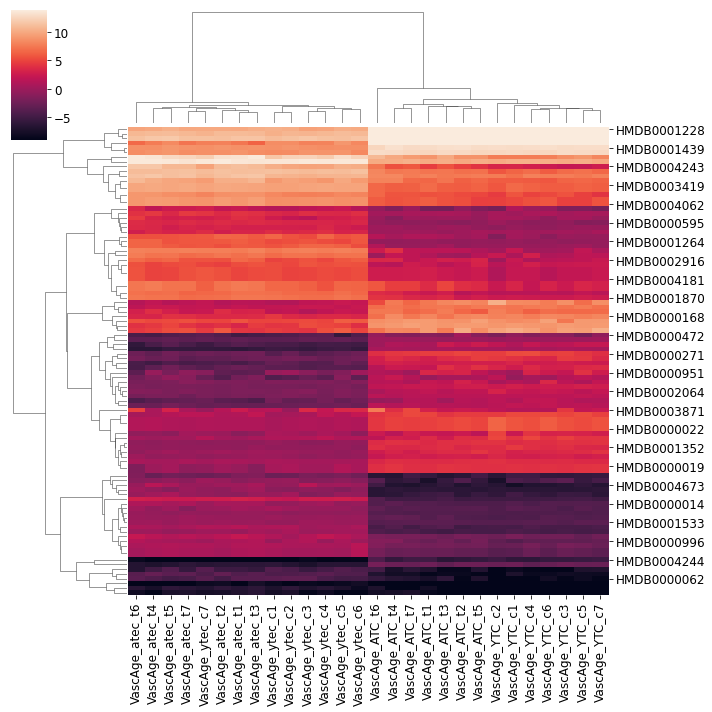

In [12]:
import seaborn as sns
met_plot_mat =  met_mat.drop("metabolite", axis = 1)
met_all_plot = met_plot_mat.loc[met_mat.var(axis = 1).sort_values(ascending = False).head(100).index]


sns.clustermap(met_all_plot, robust = True,)

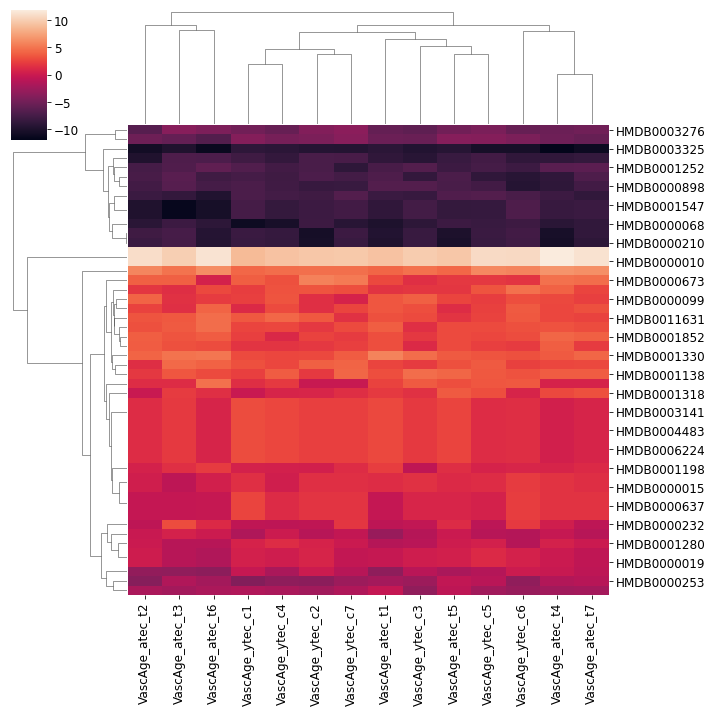

In [13]:
met_ec_mat = met_plot_mat.filter(like="tec")
met_ec_plot = met_ec_mat.loc[met_ec_mat.var(axis = 1).sort_values(ascending = False).head(50).index]
sns.clustermap(met_ec_plot, robust = False,)

In [14]:
met_ec_mat.var(axis = 1).sort_values(ascending = False)

HMDB0003871    2.371282
HMDB0000673    2.347120
HMDB0000232    1.866687
HMDB0000951    1.741414
HMDB0001547    1.475531
                 ...   
HMDB0001276    0.000000
HMDB0000257    0.000000
HMDB0002022    0.000000
HMDB0000700    0.000000
HMDB0004112    0.000000
Length: 566, dtype: float64

In [15]:


## check cutoff
def print_cutoffs(mebo_obj):
    print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
    print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

print_cutoffs(mebo_all)
print_cutoffs(mebo_young)
print_cutoffs(mebo_aged)

sensor_exp cutoff: 3.535557270050049
metabolite_presence cutoff: 1.4316289126873016
sensor_exp cutoff: 3.3956010341644287
metabolite_presence cutoff: 1.454783320426941
sensor_exp cutoff: 3.6859922409057617
metabolite_presence cutoff: 1.3896130919456482


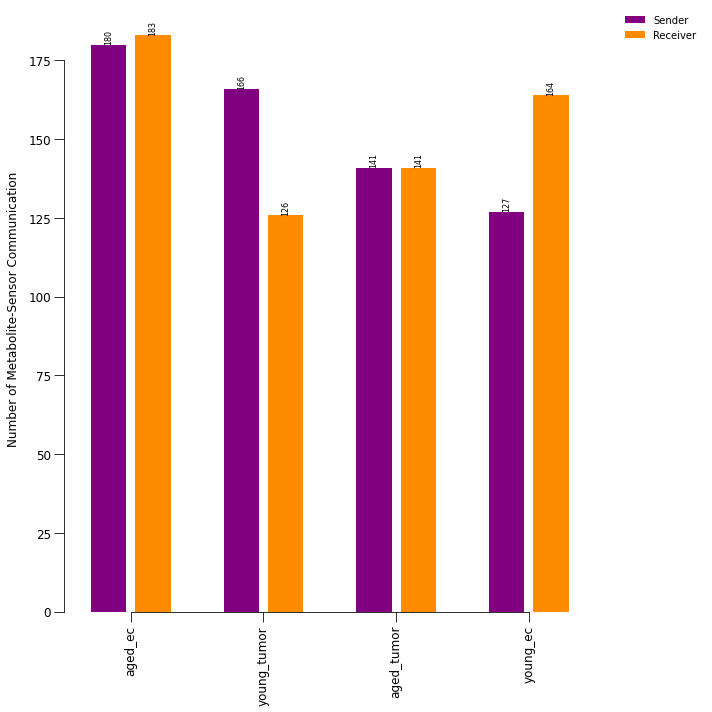

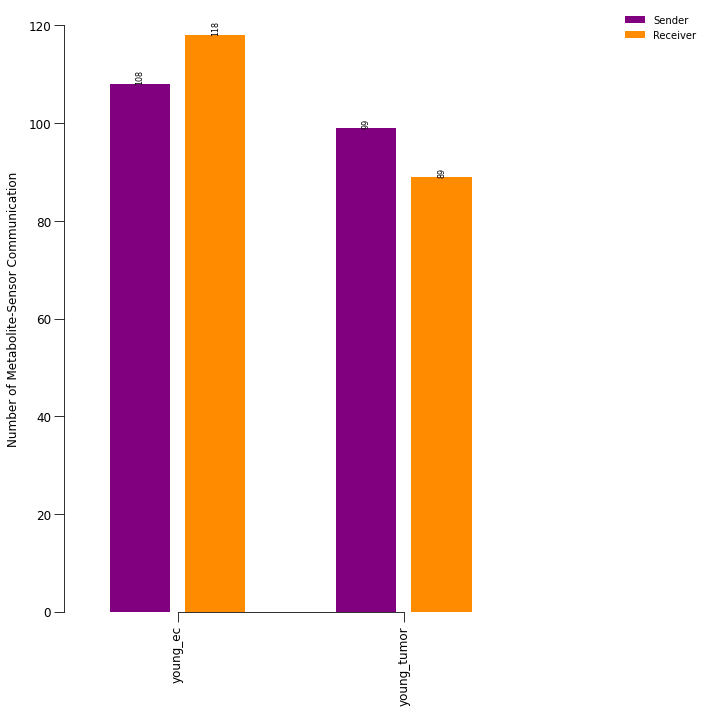

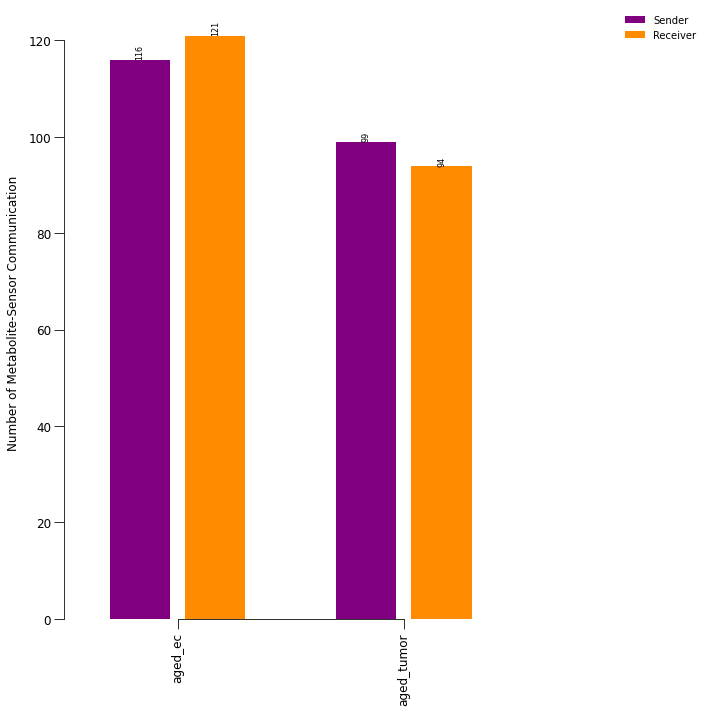

In [16]:


## sender and receiver event number
def plot_eventnum(mebo_obj):
    mebo_obj.eventnum_bar(
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    and_or='and',
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    comm_score_col='Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize=(10,10),
                    save=None,
                    show_plot=True,
                    show_num = True,
                    include=['sender-receiver'],
                    group_by_cell=True,
                    colorcmap='tab20',
                    return_fig=False
                )

        
plot_eventnum(mebo_all)
plot_eventnum(mebo_young)
plot_eventnum(mebo_aged)

[May 02, 2023 15:43:47]: show communication in cells by network plot


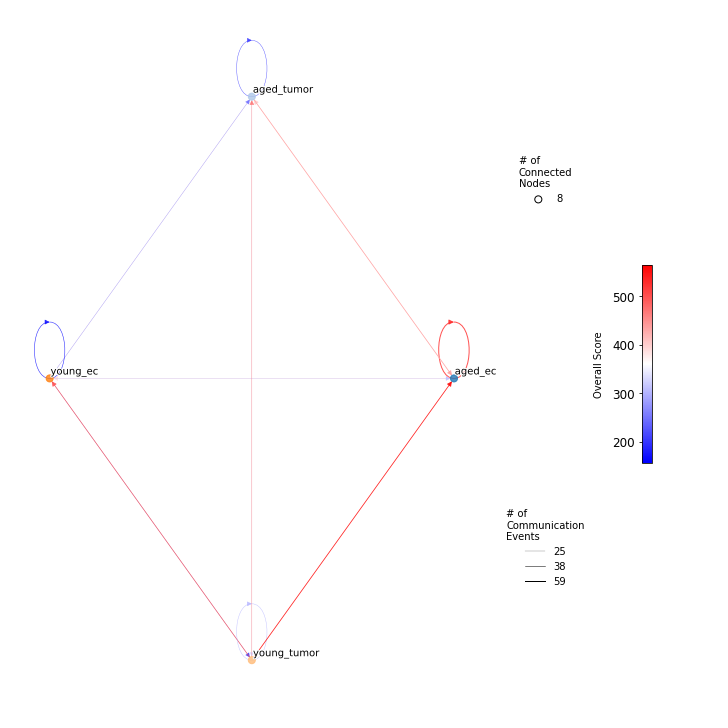

[May 02, 2023 15:43:50]: show communication in cells by network plot


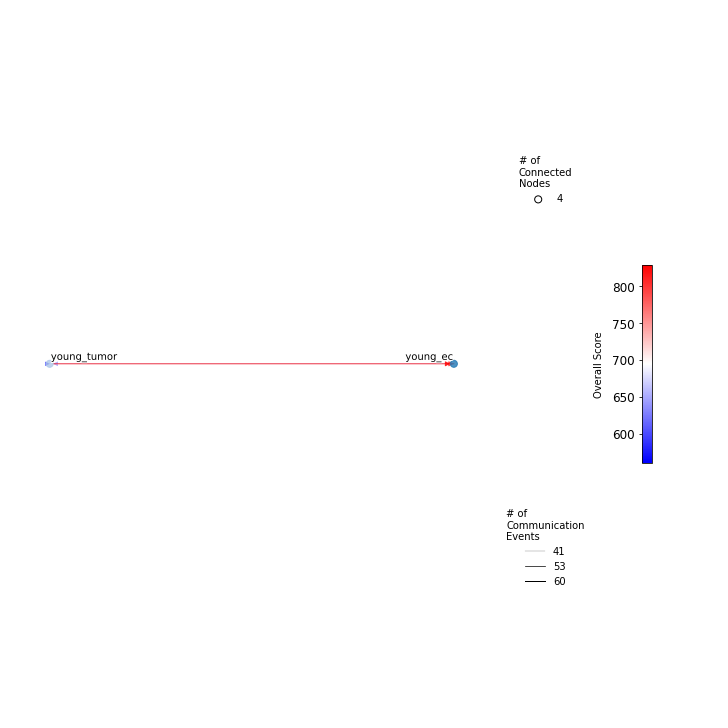

[May 02, 2023 15:43:51]: show communication in cells by network plot


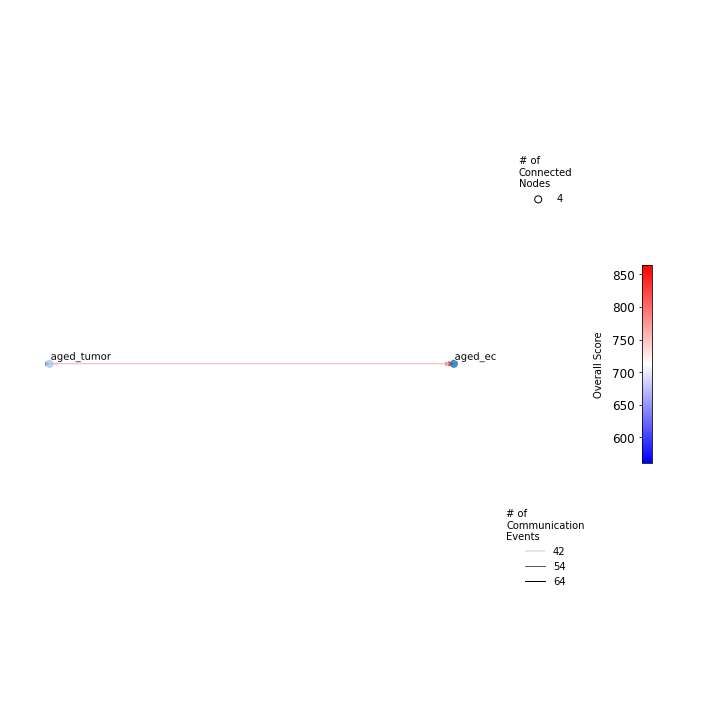

In [17]:
def plot_com_net(mebo_obj):
    mebo_obj.commu_network_plot(
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    and_or='and',
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    node_cmap='tab20',
                    figsize=(10,10),
                    line_cmap='bwr',
                    line_color_vmin=None,
                    line_color_vmax=None,
                    linewidth_norm=(0.2, 1),
                    node_size_norm=(50, 200),
                    adjust_text_pos_node=True,
                    node_text_hidden = False,
                    node_text_font=10,
                    save=None,
                    show_plot=True,
                    comm_score_col='Commu_Score',
                    comm_score_cutoff=0,
                    text_outline=True,
                    return_fig=False
                )
plot_com_net(mebo_all)
plot_com_net(mebo_young)
plot_com_net(mebo_aged)

[May 02, 2023 15:43:52]: plot dot plot to show communication in cell type level


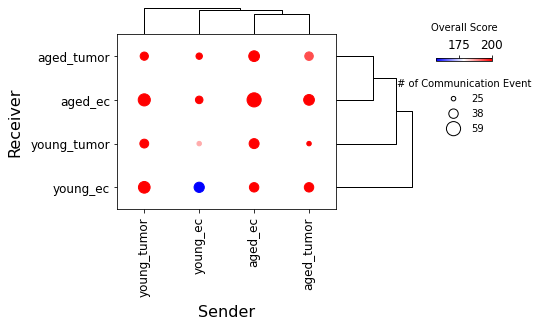

[May 02, 2023 15:43:53]: plot dot plot to show communication in cell type level


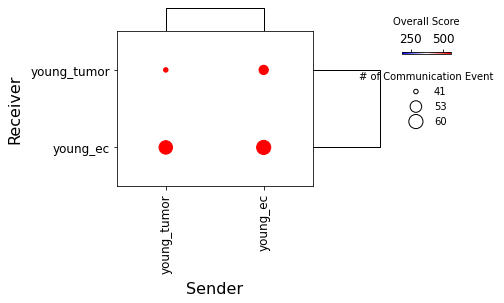

[May 02, 2023 15:43:53]: plot dot plot to show communication in cell type level


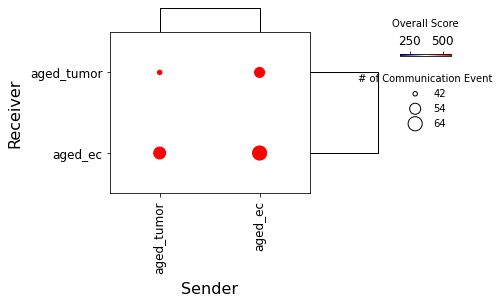

In [18]:

def plot_count_dot(mebo_obj):
    mebo_obj.count_dot_plot(
                        pval_method='permutation_test_fdr',
                        pval_cutoff=0.05,
                        cmap='bwr',
                        figsize='auto',
                        save=None,
                        dot_size_norm=(20, 200),
                        dot_color_vmin=None,
                        dot_color_vmax=200,
                        show_plot=True,
                        comm_score_col='Commu_Score',
                        comm_score_cutoff=0,
                        return_fig = False
                    )

plot_count_dot(mebo_all)
plot_count_dot(mebo_young)
plot_count_dot(mebo_aged)

[May 02, 2023 15:43:54]: plot heatmap for significant result


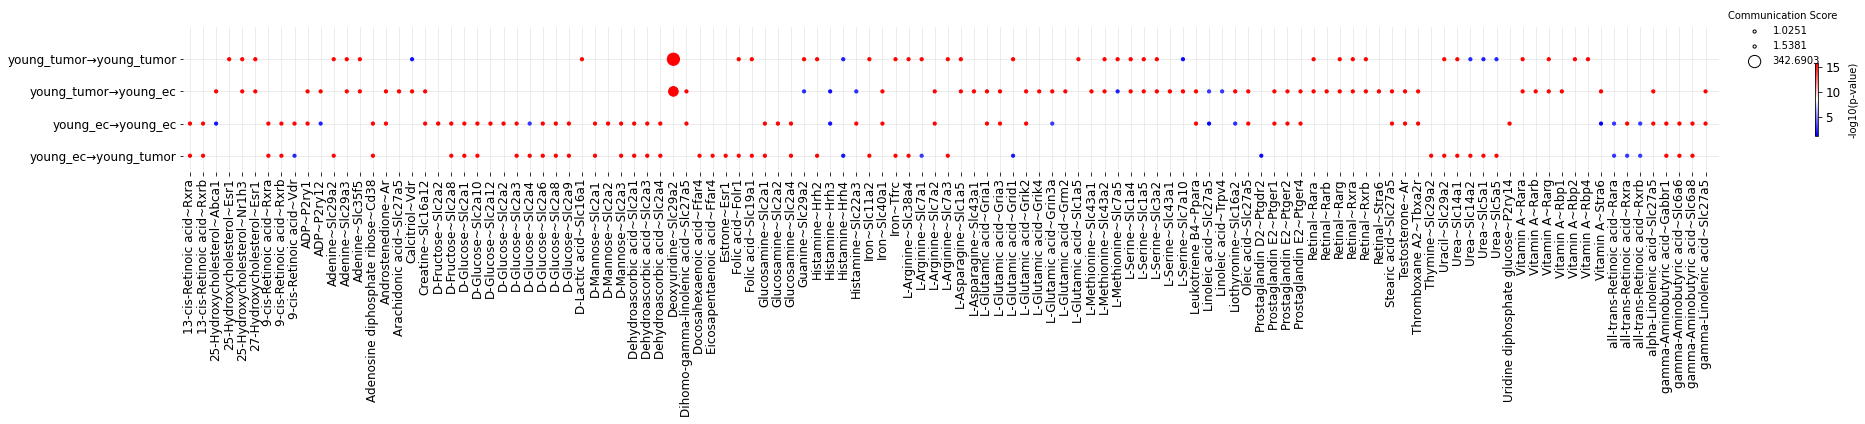

[May 02, 2023 15:43:59]: plot heatmap for significant result


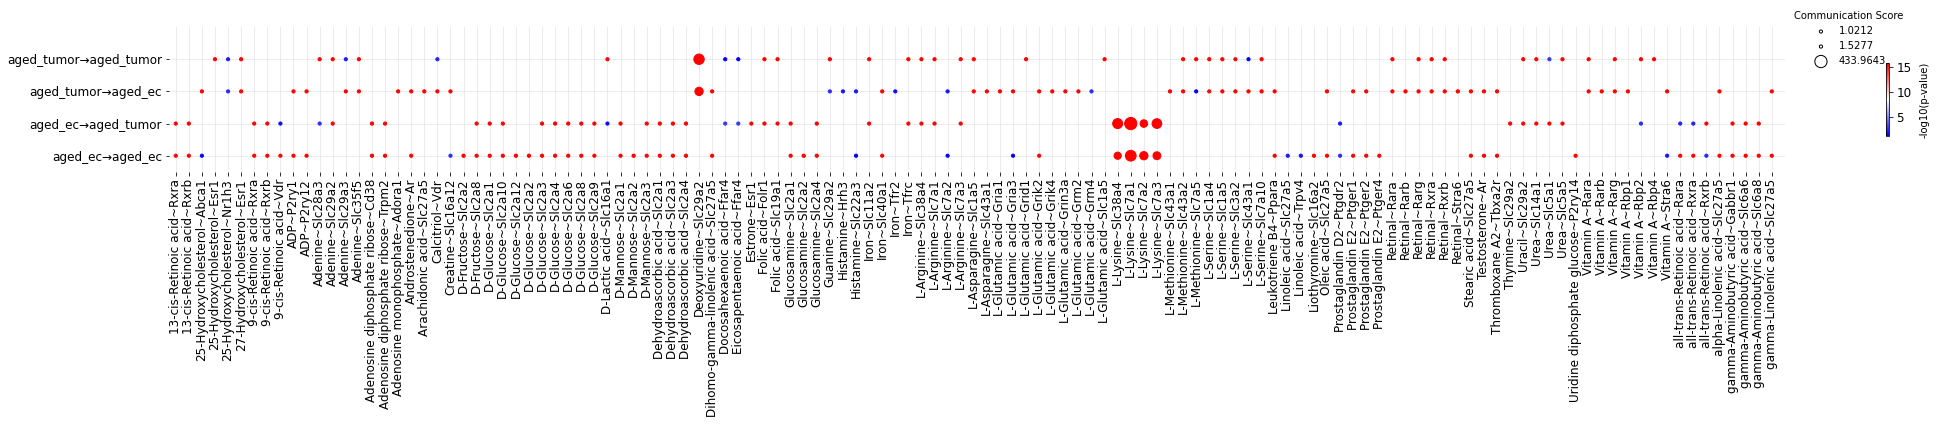

In [19]:
def plot_comm_map(mebo_obj):
    mebo_obj.commu_dotmap(
                sender_focus=[],
                metabolite_focus=[],
                sensor_focus=[],
                receiver_focus=[],
                and_or='and',
                pval_method='permutation_test_fdr',
                pval_cutoff=0.05,
                figsize='auto',
                cmap='bwr',
                node_size_norm=(10, 150),
                save=None,
                show_plot=True,
                comm_score_col='Commu_Score',
                comm_score_cutoff=0,
                swap_axis = True,
                return_fig = False
                )
    
plot_comm_map(mebo_young)
plot_comm_map(mebo_aged)

[May 02, 2023 15:44:04]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


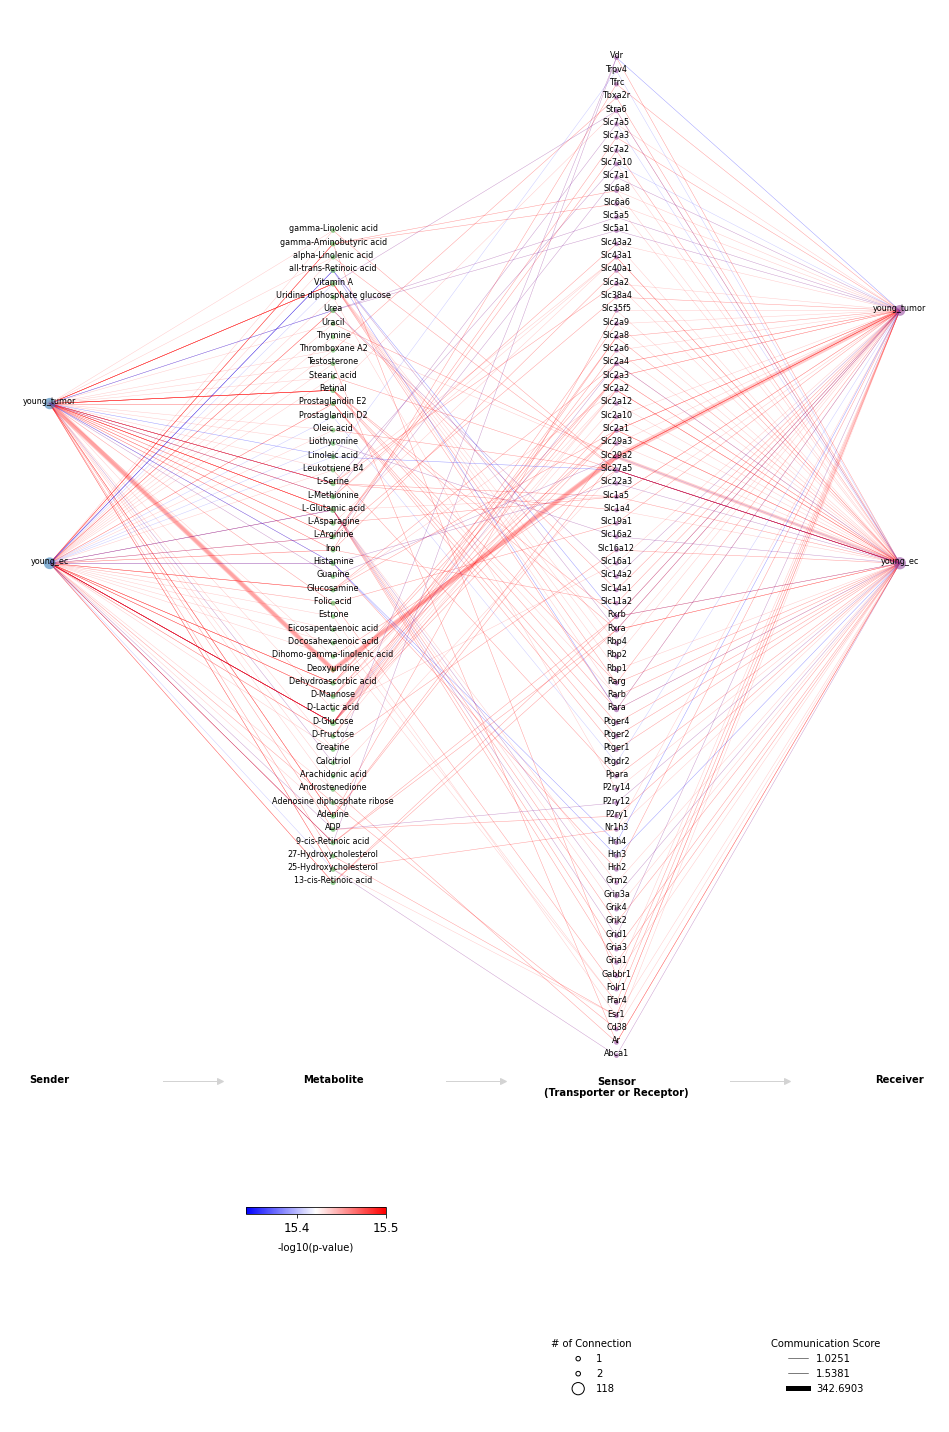

[May 02, 2023 15:44:07]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


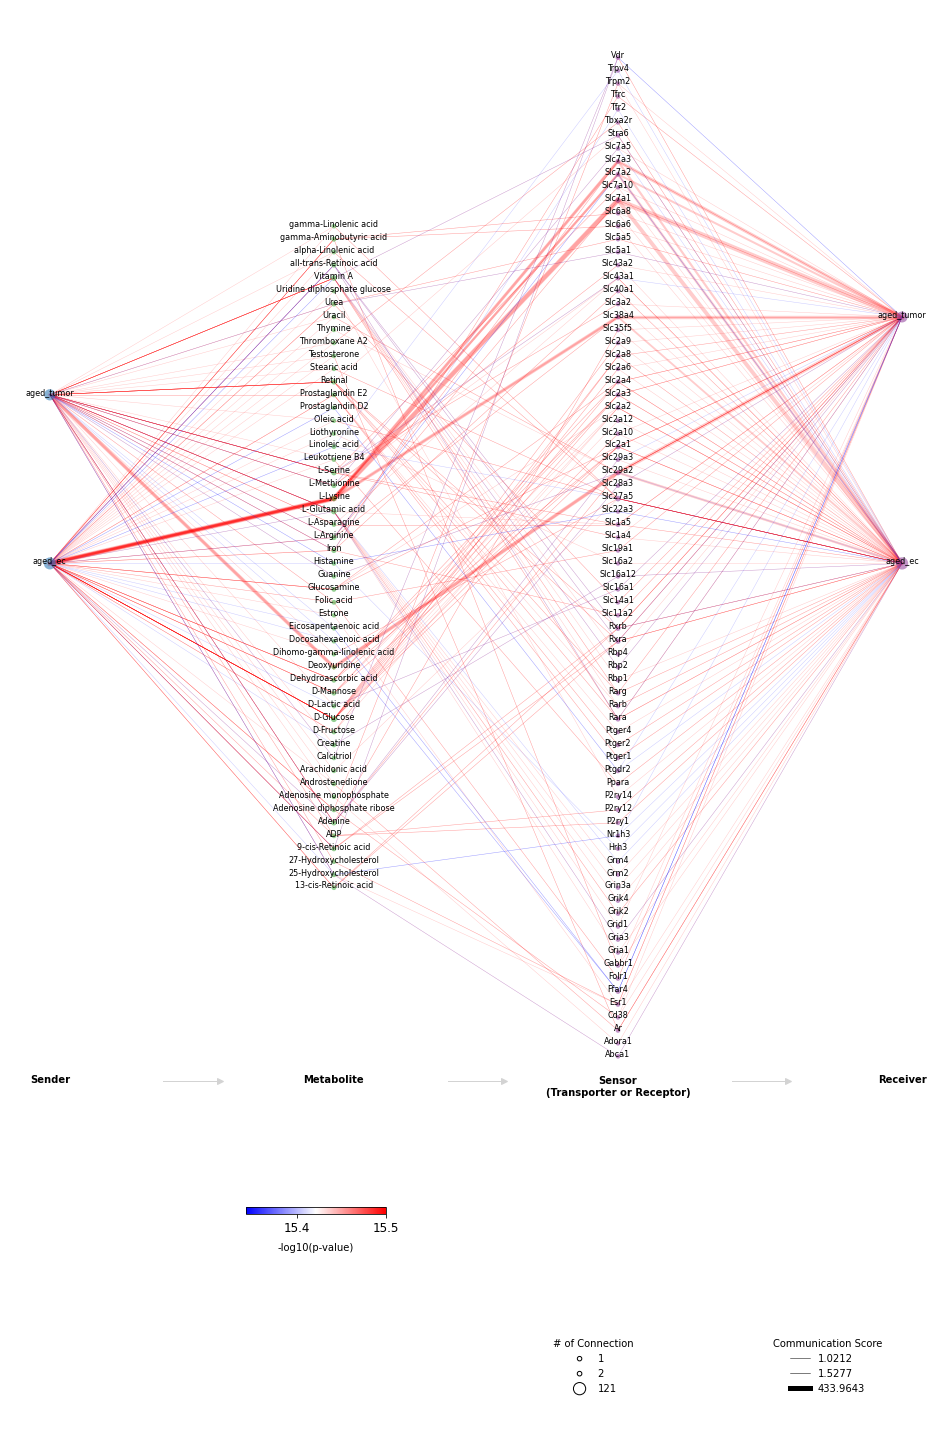

In [20]:
def plot_flow(mebo_obj):
    mebo_obj.FlowPlot(
                pval_method='permutation_test_fdr',
                pval_cutoff=0.05,
                sender_focus=[],
                sensor_focus=[],
                receiver_focus=[],
                remove_unrelevant = True,
                and_or='and',
                node_label_size=8,
                node_alpha=0.6,
                figsize=(20,20),
                node_cmap='Set1',
                line_cmap='bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm=(20, 150),
                linewidth_norm=(0.5, 5),
                save=None,
                show_plot=True,
                comm_score_col='Commu_Score',
                comm_score_cutoff=0,
                text_outline=False,
                return_fig = False
            )
    

plot_flow(mebo_young)
plot_flow(mebo_aged)

[May 02, 2023 15:54:26]: Warnings: no sensors to plot
[May 02, 2023 15:54:26]: Find metabolites ['Adenosine diphosphate ribose', '9-cis-Retinoic acid', 'ADP', 'Androstenedione', 'Adenosine monophosphate', '25-Hydroxycholesterol', '27-Hydroxycholesterol', 'Arachidonic acid', '13-cis-Retinoic acid', 'Adenine'] to plot violin


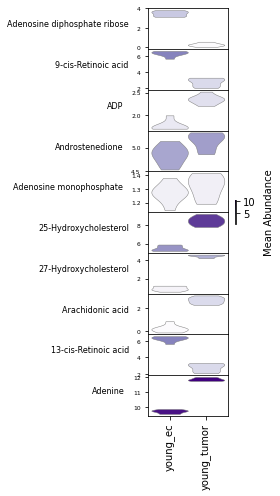

In [36]:
commu_df = mebo_all.commu_res.copy()
commu_young = mebo_young.commu_res.copy()
commu_aged = mebo_aged.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_young.violin_plot(
                    sensor_or_met=good_met[:10], ## only top 5 as example
                    cell_focus=[],
                    cmap=None,
                    vmin=None,
                    vmax=None,
                    figsize='auto',
                    cbar_title='',
                    save=None,
                    show_plot=True
                    )

[May 02, 2023 15:44:11]: Find genes Index(['Adora1', 'Abca1', 'Cd38', 'Folr1', 'Esr1', 'Gria1', 'Gabbr1', 'Ffar4',
       'Gria3', 'Ar'],
      dtype='object', name='gene') to plot violin


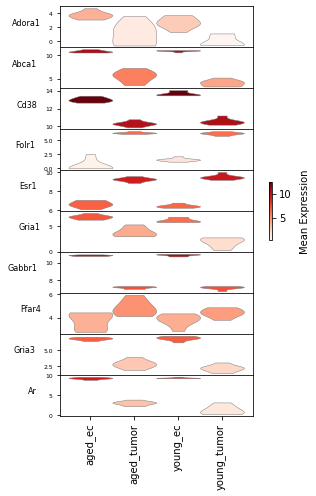

[May 02, 2023 15:44:12]: Warnings: no metabolites to plot


In [22]:
good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_all.violin_plot(
                    sensor_or_met=good_sensor[:10],## only top 5 as example
                    cell_focus=[],
                    cmap=None,
                    vmin=None,
                    vmax=None,
                    figsize='auto',
                    cbar_title='',
                    save=None,
                    show_plot=True
                    )


## Attempt at anaylzing DE expression

In [23]:
commu_res = mebo_all.commu_res.copy()
mebo_test = mebo_all

In [24]:
commu_res['sender_cond'] = [x.split("_")[-2] for x in commu_res['Sender'].tolist()]
commu_res['receiver_cond'] = [x.split("_")[-2] for x in commu_res['Receiver'].tolist()]
commu_res_new = pd.DataFrame()
for c in commu_res['sender_cond'].unique().tolist():
    tmp = commu_res[(commu_res['sender_cond'] == c) & (commu_res['receiver_cond'] == c)]
    commu_res_new = pd.concat([commu_res_new, tmp])

mebo_test.commu_res = commu_res_new.copy()


In [25]:
commu_res

,Sender,Metabolite,Metabolite_Name,Receiver,Sensor,Commu_Score,metabolite_prop_in_sender,sensor_prop_in_receiver,ztest_stat,ztest_pval,...,ranksum_test_stat,ranksum_test_pval,permutation_test_stat,permutation_test_pval,ztest_fdr,ttest_fdr,ranksum_test_fdr,permutation_test_fdr,sender_cond,receiver_cond
7,young_tumor,HMDB0006247,25-Hydroxycholesterol,young_ec,Abca1,1.803210,1.000000,1.000000,-210.823702,0.0,...,-1.731185,0.041709,0,0.0,0.0,8.880091e-05,0.145888,0.0,young,young
5,young_tumor,HMDB0000517,L-Arginine,young_tumor,Slc38a4,1.409473,1.000000,1.000000,-140.275284,0.0,...,-1.731185,0.041709,0,0.0,0.0,5.911255e-03,0.145888,0.0,young,young
7,young_tumor,HMDB0001043,Arachidonic acid,young_ec,Slc27a5,3.025930,1.000000,1.000000,-235.117963,0.0,...,-1.731185,0.041709,0,0.0,0.0,1.092059e-05,0.145888,0.0,young,young
14,young_ec,HMDB0000122,D-Glucose,aged_ec,Slc2a2,3.443699,0.285714,1.000000,-303.077716,0.0,...,-1.731185,0.041709,0,0.0,0.0,9.275586e-09,0.145888,0.0,young,aged
11,aged_ec,HMDB0000122,D-Glucose,young_ec,Slc2a2,3.413985,0.428571,1.000000,-299.533982,0.0,...,-1.731185,0.041709,0,0.0,0.0,1.264218e-08,0.145888,0.0,aged,young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,young_ec,HMDB0000538,Adenosine triphosphate,young_tumor,P2rx5,-175.788084,0.000000,1.000000,-22.255114,1.0,...,-0.635345,1.000000,633,1.0,1.0,1.000000e+00,1.000000,1.0,young,young
4,young_tumor,HMDB0000158,L-Tyrosine,aged_tumor,Slc16a10,-279.095134,0.000000,0.285714,-21.716509,1.0,...,-0.633614,1.000000,634,1.0,1.0,1.000000e+00,1.000000,1.0,young,aged
1,aged_tumor,HMDB0000538,Adenosine triphosphate,young_tumor,P2rx7,-307.046324,0.000000,1.000000,-22.450116,1.0,...,-0.631883,1.000000,635,1.0,1.0,1.000000e+00,1.000000,1.0,aged,young
15,young_ec,HMDB0000248,Thyroxine,young_ec,Slc16a2,-259.443200,0.000000,1.000000,-26.130352,1.0,...,-0.782496,1.000000,548,1.0,1.0,1.000000e+00,1.000000,1.0,young,young


In [26]:
commu_res_new['label'] = commu_res_new['Sender'].apply(lambda x: x.split('_')[1])+'~'+commu_res_new['Metabolite_Name']+'~'+commu_res_new['Sensor']+'~'+commu_res_new['Receiver'].apply(lambda x: x.split('_')[1])
significant = commu_res_new[commu_res_new['permutation_test_fdr'] < 0.05]

In [27]:
significant

,Sender,Metabolite,Metabolite_Name,Receiver,Sensor,Commu_Score,metabolite_prop_in_sender,sensor_prop_in_receiver,ztest_stat,ztest_pval,...,ranksum_test_pval,permutation_test_stat,permutation_test_pval,ztest_fdr,ttest_fdr,ranksum_test_fdr,permutation_test_fdr,sender_cond,receiver_cond,label
7,young_tumor,HMDB0006247,25-Hydroxycholesterol,young_ec,Abca1,1.803210,1.000000,1.0,-210.823702,0.0,...,0.041709,0,0.0000,0.0,0.000089,0.145888,0.000000,young,young,tumor~25-Hydroxycholesterol~Abca1~ec
5,young_tumor,HMDB0000517,L-Arginine,young_tumor,Slc38a4,1.409473,1.000000,1.0,-140.275284,0.0,...,0.041709,0,0.0000,0.0,0.005911,0.145888,0.000000,young,young,tumor~L-Arginine~Slc38a4~tumor
7,young_tumor,HMDB0001043,Arachidonic acid,young_ec,Slc27a5,3.025930,1.000000,1.0,-235.117963,0.0,...,0.041709,0,0.0000,0.0,0.000011,0.145888,0.000000,young,young,tumor~Arachidonic acid~Slc27a5~ec
13,young_ec,HMDB0000122,D-Glucose,young_tumor,Slc2a3,1.957570,0.285714,1.0,-147.217422,0.0,...,0.041709,0,0.0000,0.0,0.004187,0.145888,0.000000,young,young,ec~D-Glucose~Slc2a3~tumor
7,young_tumor,HMDB0000187,L-Serine,young_ec,Slc43a1,2.445239,1.000000,1.0,-197.888358,0.0,...,0.041709,0,0.0000,0.0,0.000251,0.145888,0.000000,young,young,tumor~L-Serine~Slc43a1~ec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,aged_tumor,HMDB0000305,Vitamin A,aged_tumor,Rarg,1.170802,1.000000,1.0,-100.202786,0.0,...,0.045054,21,0.0105,0.0,0.042675,0.145888,0.034949,aged,aged,tumor~Vitamin A~Rarg~tumor
0,aged_tumor,HMDB0000294,Urea,aged_tumor,Slc5a1,1.242841,1.000000,1.0,-90.485182,0.0,...,0.045054,21,0.0105,0.0,0.066787,0.145888,0.034949,aged,aged,tumor~Urea~Slc5a1~tumor
2,aged_tumor,HMDB0000187,L-Serine,aged_ec,Slc1a5,1.525663,1.000000,1.0,-97.725554,0.0,...,0.045549,24,0.0120,0.0,0.048092,0.145888,0.039452,aged,aged,tumor~L-Serine~Slc1a5~ec
0,aged_tumor,HMDB0000305,Vitamin A,aged_tumor,Rara,1.187841,1.000000,1.0,-99.256431,0.0,...,0.046048,27,0.0135,0.0,0.044670,0.145888,0.043784,aged,aged,tumor~Vitamin A~Rara~tumor


In [28]:
commu_res_need = commu_res_new[commu_res_new['label'].isin(significant['label'])]

commu_res_need_mat = commu_res_need.pivot_table(index = 'label', columns = 'sender_cond', values = 'Commu_Score')


In [29]:
IOD = commu_res_need_mat.apply(lambda row: np.var(row)/np.mean(row), axis = 1).sort_values(ascending=False)

In [30]:
commu_res_need_mat

sender_cond,aged,young
label,,
ec~13-cis-Retinoic acid~Rxra~ec,1.458896,1.254286
ec~13-cis-Retinoic acid~Rxra~tumor,1.338662,1.161662
ec~13-cis-Retinoic acid~Rxrb~ec,1.365406,1.191882
ec~13-cis-Retinoic acid~Rxrb~tumor,1.417046,1.240978
ec~25-Hydroxycholesterol~Abca1~ec,1.063120,1.193894
...,...,...
tumor~Vitamin A~Rbp2~tumor,1.990084,2.122245
tumor~Vitamin A~Rbp4~tumor,1.633447,1.772214
tumor~Vitamin A~Stra6~ec,2.114206,2.569431


In [31]:
top_n = 100
most_var_commu = commu_res_need_mat.loc[IOD.head(top_n).index]
most_var_commu = pd.concat([most_var_commu,
                            pd.DataFrame(most_var_commu.index.str.split('~').tolist(),
                                         index = most_var_commu.index, 
                                         columns = ['Sender', 'Met', 'Sensor', 'Receiver'])],
                          axis = 1)

In [37]:
with pd.ExcelWriter("MEBOCOST.xlsx") as writer:
    most_var_commu.to_excel(writer, sheet_name="most variable communicaiton")
    met_mat.to_excel(writer, sheet_name="Metabolites")
    commu_res.to_excel(writer,sheet_name="All Communication")
    commu_young.to_excel(writer, sheet_name="Young Communication")
    commu_aged.to_excel(writer, sheet_name="Aged Communication")

AttributeError: 'DataFrame' object has no attribute 'to_xlsx'

In [ ]:
good_sensor

[May 02, 2023 15:57:10]: Find genes Index(['Rxra', 'Slc7a1', 'Slc27a5', 'Slc7a2', 'Stra6', 'Rarb', 'Slc38a4',
       'Slc29a2', 'Slc7a3', 'Slc16a2'],
      dtype='object', name='gene') to plot violin


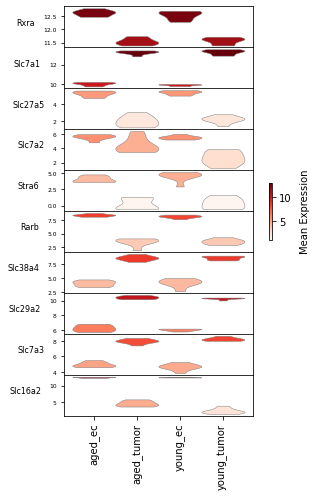

[May 02, 2023 15:57:11]: Warnings: no metabolites to plot


In [38]:
mebo_all.violin_plot(
                    sensor_or_met=most_var_commu.Sensor.unique()[:10], ## only top 5 as example
                    cell_focus=[],
                    cmap=None,
                    vmin=None,
                    vmax=None,
                    figsize='auto',
                    cbar_title='',
                    save=None,
                    show_plot=True
                    )

[May 02, 2023 15:57:11]: Warnings: no sensors to plot
[May 02, 2023 15:57:11]: Find metabolites ['Retinal', 'Deoxyuridine', 'Arachidonic acid', 'all-trans-Retinoic acid', 'Linoleic acid', 'Adenosine monophosphate', 'L-Lysine', 'L-Glutamic acid', 'Liothyronine', 'Adenosine diphosphate ribose'] to plot violin


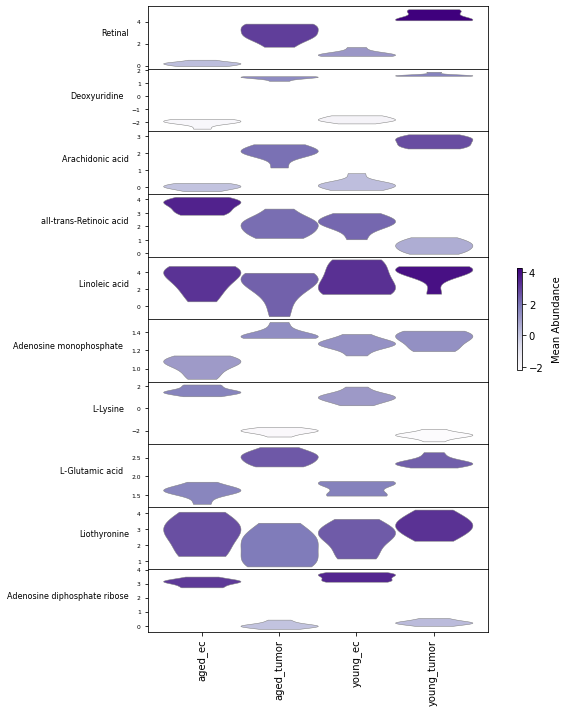

In [39]:
mebo_test.violin_plot(
                    sensor_or_met=most_var_commu.Met.unique()[:10], ## only top 5 as example
                    cell_focus=[],
                    cmap=None,
                    vmin=None,
                    vmax=None,
                    figsize=(8,10),
                    cbar_title='',
                    save=None,
                    show_plot=True
                    )

[May 02, 2023 15:57:12]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


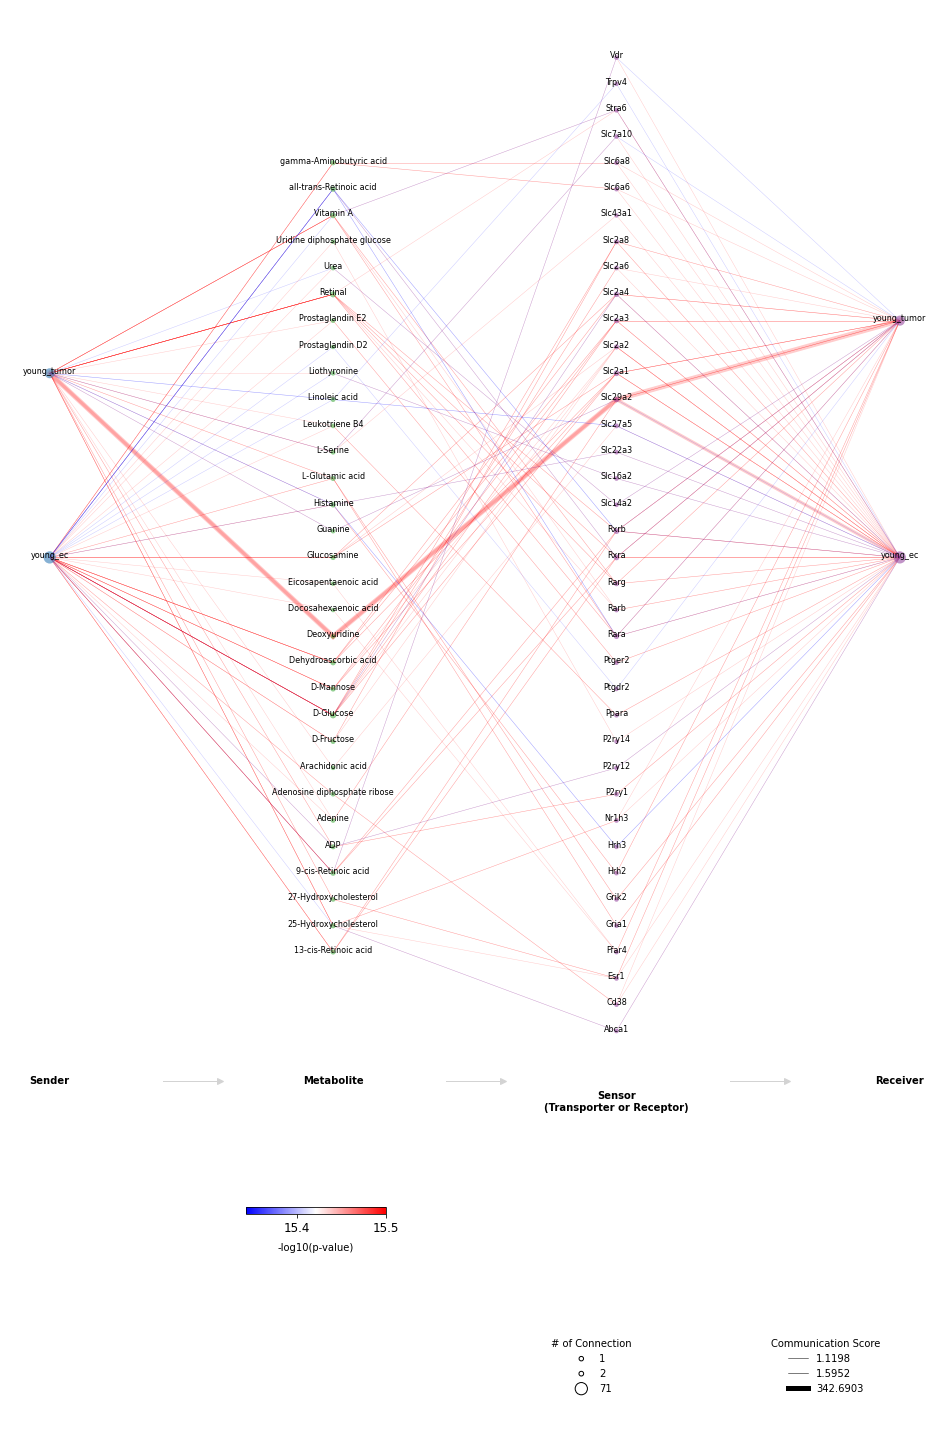

In [40]:
mebo_young.FlowPlot(
                pval_method='permutation_test_fdr',
                pval_cutoff=0.05,
                sender_focus=[],
                metabolite_focus=most_var_commu.Met.unique().tolist(),
                sensor_focus=most_var_commu.Sensor.unique().tolist(),
                receiver_focus=[],
                remove_unrelevant = True,
                and_or='and',
                node_label_size=8,
                node_alpha=0.6,
                figsize=(20,20),
                node_cmap='Set1',
                line_cmap='bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm=(20, 150),
                linewidth_norm=(0.5, 5),
                save=None,
                show_plot=True,
                comm_score_col='Commu_Score',
                comm_score_cutoff=0,
                text_outline=False,
                return_fig = False
            )

In [ ]:
most_var_commu.Met.unique().tolist(),

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(most_var_commu)
    display(most_var_commu.Met)
    
most_var_com.to

In [ ]:
mebo_young.gmt_path =  "/desktop-home/heyer/projects/Vascular_Aging/RNAseq/multicondition-deseq2-enrichment/custom/m2.all.v2022.1.Mm.symbols.gmt"